In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

In [15]:
df = pd.read_csv("./data/grouped_irradiance/grouped_irradiance.csv", delim_whitespace=True, parse_dates=["Time"])

In [43]:
df = df.assign(eff_irradiance=(df.irr_dir * 0.9))
df.head()

,Time,irr_g,irr_dir,irr_diff,temp,city,eff_irradiance
0,2010-01-01 00:00:00,0.0,0.0,0.0,-0.18,Zurich,0.0
1,2010-01-01 01:00:00,0.0,0.0,0.0,-0.06,Zurich,0.0
2,2010-01-01 02:00:00,0.0,0.0,0.0,0.06,Zurich,0.0
3,2010-01-01 03:00:00,0.0,0.0,0.0,0.18,Zurich,0.0
4,2010-01-01 04:00:00,0.0,0.0,0.0,0.07,Zurich,0.0


Text(0.5, 0, '')

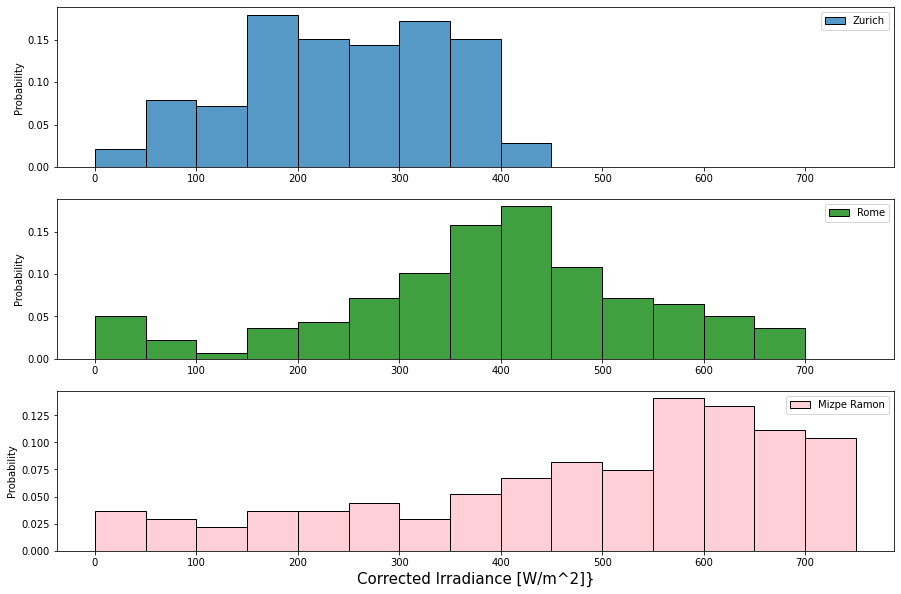

In [52]:
bins_irr = np.arange(0,800,50)
fig, ax = plt.subplots(3,1,figsize=(15,10))
sns.histplot(data=df[(df.eff_irradiance > 0)&(df.city =="Zurich")], x="eff_irradiance", stat="probability", ax=ax[0], bins=bins_irr)
sns.histplot(data=df[(df.eff_irradiance > 0)&(df.city =="Rome")], x="eff_irradiance", stat="probability", ax=ax[1], bins=bins_irr, color="green")
sns.histplot(data=df[(df.eff_irradiance > 0)&(df.city =="Mizpe")], x="eff_irradiance", stat="probability", ax=ax[2], bins=bins_irr, color="pink")
ax[2].set_xlabel("Corrected Irradiance [W/m^2]}", fontsize=15)
ax[0].legend(["Zurich"])
ax[1].legend(["Rome"])
ax[2].legend(["Mizpe Ramon"])
ax[0].set_xlabel("")
ax[1].set_xlabel("")

Text(0.5, 0, '')

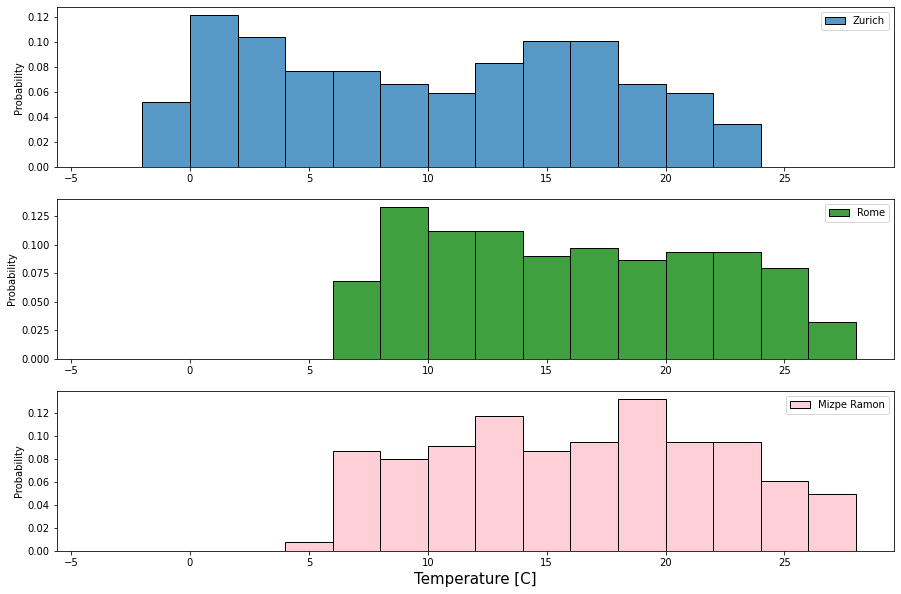

In [55]:
bins_temp = np.arange(-4,30,2)
fig, ax = plt.subplots(3,1,figsize=(15,10))
sns.histplot(data=df[(df.city =="Zurich")], x="temp", stat="probability", ax=ax[0], bins=bins_temp)
sns.histplot(data=df[(df.city =="Rome")], x="temp", stat="probability", ax=ax[1], bins=bins_temp, color="green")
sns.histplot(data=df[(df.city =="Mizpe")], x="temp", stat="probability", ax=ax[2], bins=bins_temp, color="pink")
ax[0].legend(["Zurich"])
ax[1].legend(["Rome"])
ax[2].legend(["Mizpe Ramon"])
ax[2].set_xlabel("Temperature [C]", fontsize=15)
ax[0].set_xlabel("")
ax[1].set_xlabel("")

In [61]:
#sns.scatterplot(data=df[(df.Time.dt.month == 8)&(df.city == "Zurich")], x="Time", y="temp")